In [1]:
# Libs padrão
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
from datetime import datetime, timedelta

# Lib Bigquery
from google.cloud import bigquery

# Lib Lifelines
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test
from lifelines.utils import survival_table_from_events

# Lib multiprocessamento
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

In [2]:
# Mostrar todas as colunas do dataset
pd.options.display.max_columns = 1000

# Importar dataset fake

In [3]:
# Conectar ao GCP e Bigquery
client = bigquery.Client()
table_id = "kaplan-meier.fake.dataset"
table = client.get_table(table_id)

In [4]:
# Importar dataset a partir da Bigquery
df = client.list_rows(table).to_dataframe()

/home/leandro/anaconda3/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1563: UserWarning: Dependency google-cloud-bigquery-storage is outdated, please upgrade it to version >= 2.0.0 (version found: 0.0.0).
  warnings.warn(str(exc))


In [5]:
# Visualizar o dataset
df.head()

,DataPrimeiraConsulta,DataUltimaConsulta,Data Obito,Óbito
0,1997-08-27,None,None,N
1,2018-03-08,None,None,N
2,None,None,None,N
3,2019-02-11,None,None,N
4,2019-11-14,None,None,N


## Preparo do dataset fake

In [7]:
# Verficar a quantidade de pacientes com a informação de vivo ou morto
df["Óbito"].value_counts(dropna=False)

N    8941
S    2128
Name: Óbito, dtype: int64

In [8]:
# Transformar o obito em True e False e salvar na coluna status_vital
df['status_vital'] = df['Óbito']
df['status_vital'] = df['status_vital'].mask(df['status_vital'] == "S", True)
df['status_vital'] = df['status_vital'].mask(df['status_vital'] == "N", False)

In [9]:
# Verificar as quantidades de
# True = MORTO
# False = VIVO
df["status_vital"].value_counts(dropna=False)

False    8941
True     2128
Name: status_vital, dtype: int64

In [10]:
# Verificar se existem dados faltantes nas datas de primeira consulta
# Não podemos ter dados faltantes na coluna de primeira consulta
df['DataPrimeiraConsulta'].isna().sum()

17

In [11]:
# Pegar todos que tenham data de de primeira consulta 
# Vamos chamar de startdate
# Não podemos ter dados faltantes!!!
df_parcial = df[-df["DataPrimeiraConsulta"].isna()]

In [15]:
# Verificar dados nulos com as datas de obito
# Quem não tem data de óbito possivelmente será censurado e precisa ter a data de último contato
df_parcial['Data Obito'].isna().sum()

9124

In [16]:
# Pegar todos que tenham data de óbito e tenha o óbito confirmado
# Descartar quem morreu e não tem data do óbito
df_morto = df_parcial[df_parcial['status_vital'] == True]
df_morto = df_morto[-df_morto['Data Obito'].isna()]

In [17]:
# Verificar dados nulos com as datas de última consulta
# Todos devem ter a data de última consulta ou de morte
df_parcial['DataUltimaConsulta'].isna().sum()

324

In [18]:
# Pegar todos que tem data de último contato caso estejam vivo ou não tenha informação
# Descartar quem está vivo e não tem data do último contato
df_vivo = df_parcial[df_parcial['status_vital'] == False]
df_vivo = df_vivo[-df_vivo['DataUltimaConsulta'].isna()]

In [19]:
# Contatenar os datasets de quem morreu e quem tá vivo e contenha as infos (Data do óbito e data do último contato) necessárias 
df_final = df_morto.append(df_vivo, ignore_index=False)
df_final

,DataPrimeiraConsulta,DataUltimaConsulta,Data Obito,Óbito,status_vital
8941,1994-01-12,None,2017-08-22,S,True
8942,2014-05-15,None,2017-08-29,S,True
8943,2015-05-18,None,2015-08-24,S,True
8944,2019-05-06,None,2019-06-13,S,True
8945,2015-01-07,None,2017-05-18,S,True
...,...,...,...,...,...
8936,2018-12-27,2021-03-01,None,N,False
8937,2019-01-11,2021-03-01,None,N,False
8938,2019-08-16,2021-03-01,None,N,False
8939,2002-05-03,2021-11-12,None,N,False


In [20]:
# Verificar quantos Mortos e Vivos após as eliminações dos pacientes com dados faltantes
df_final['status_vital'].value_counts(dropna=False)

False    8875
True     1928
Name: status_vital, dtype: int64

In [21]:
# Formatar as datas para pegar a informação de duração da sobrevida
df_final['DataPrimeiraConsulta'] = pd.to_datetime(df_final['DataPrimeiraConsulta'], format='%Y-%m-%d')
df_final['Data Obito'] = pd.to_datetime(df_final['Data Obito'], format='%Y-%m-%d')
df_final['DataUltimaConsulta'] = pd.to_datetime(df_final['DataUltimaConsulta'], format='%Y-%m-%d')

In [22]:
# Criar coluna com o enddate os pacientes
# Caso o paciente morreru a coluna enddate considerará a data do óbito
# Caso o paciente esteja vivo a coluna enddate considerará a data do último contato
mortos = df_final['status_vital'] == True
vivos = df_final['status_vital'] == False
teste_mortos = df_final['Data Obito'][mortos]
teste_vivos = df_final['DataUltimaConsulta'][vivos]

# Contatenar o dataset findal com a coluna enddate
df_final['enddate'] = pd.concat([teste_mortos, teste_vivos], axis=0)

In [23]:
# Transformar a coluna para o formato float que é esperado pelo pacote Lifelines
# True = MORTO = 0
# False = VIVO = 1.0
df_final['desfecho'] = df_final['status_vital'].astype(np.float64)

In [24]:
# Visualiar o dataset final
df_final

,DataPrimeiraConsulta,DataUltimaConsulta,Data Obito,Óbito,status_vital,enddate,obito_float
8941,1994-01-12,NaT,2017-08-22,S,True,2017-08-22,1.0
8942,2014-05-15,NaT,2017-08-29,S,True,2017-08-29,1.0
8943,2015-05-18,NaT,2015-08-24,S,True,2015-08-24,1.0
8944,2019-05-06,NaT,2019-06-13,S,True,2019-06-13,1.0
8945,2015-01-07,NaT,2017-05-18,S,True,2017-05-18,1.0
...,...,...,...,...,...,...,...
8936,2018-12-27,2021-03-01,NaT,N,False,2021-03-01,0.0
8937,2019-01-11,2021-03-01,NaT,N,False,2021-03-01,0.0
8938,2019-08-16,2021-03-01,NaT,N,False,2021-03-01,0.0
8939,2002-05-03,2021-11-12,NaT,N,False,2021-11-12,0.0


## Preparo da variável duração com multiprocessador

In [25]:
# Função para coletar o tempo (duração) de sobrevidade cada paciente
# Tempo até a morte
# Ou tempo até último contato
# Definido o tempo em meses
def coleta_tempo(i):
    dataframe = df_final.copy()
    return dataframe['enddate'].dt.to_period('M').astype(int)[i] - dataframe['DataPrimeiraConsulta'].dt.to_period('M').astype(int)[i]

In [26]:
# Coletar o tempo utilizando multiprocessamento (agilizar o processo)
duracao = process_map(coleta_tempo, df_final.index, max_workers=8, chunksize=10)

In [27]:
# Criar a coluna no dataset final com os tempo coletados
df_final['duracao'] = duracao
# Selecionar os pacientes que possuem o tempo maior que 0 para criar o gráfico
df_final_use = df_final[df_final['duracao'] > 0]
# Visualizar o dataset final
df_final_use

,DataPrimeiraConsulta,DataUltimaConsulta,Data Obito,Óbito,status_vital,enddate,obito_float,duracao
8941,1994-01-12,NaT,2017-08-22,S,True,2017-08-22,1.0,283
8942,2014-05-15,NaT,2017-08-29,S,True,2017-08-29,1.0,39
8943,2015-05-18,NaT,2015-08-24,S,True,2015-08-24,1.0,3
8944,2019-05-06,NaT,2019-06-13,S,True,2019-06-13,1.0,1
8945,2015-01-07,NaT,2017-05-18,S,True,2017-05-18,1.0,28
...,...,...,...,...,...,...,...,...
8936,2018-12-27,2021-03-01,NaT,N,False,2021-03-01,0.0,27
8937,2019-01-11,2021-03-01,NaT,N,False,2021-03-01,0.0,26
8938,2019-08-16,2021-03-01,NaT,N,False,2021-03-01,0.0,19
8939,2002-05-03,2021-11-12,NaT,N,False,2021-11-12,0.0,234


## Análise da KM com pacote LIFELINES do dataset fake

(0.0, 1.0)

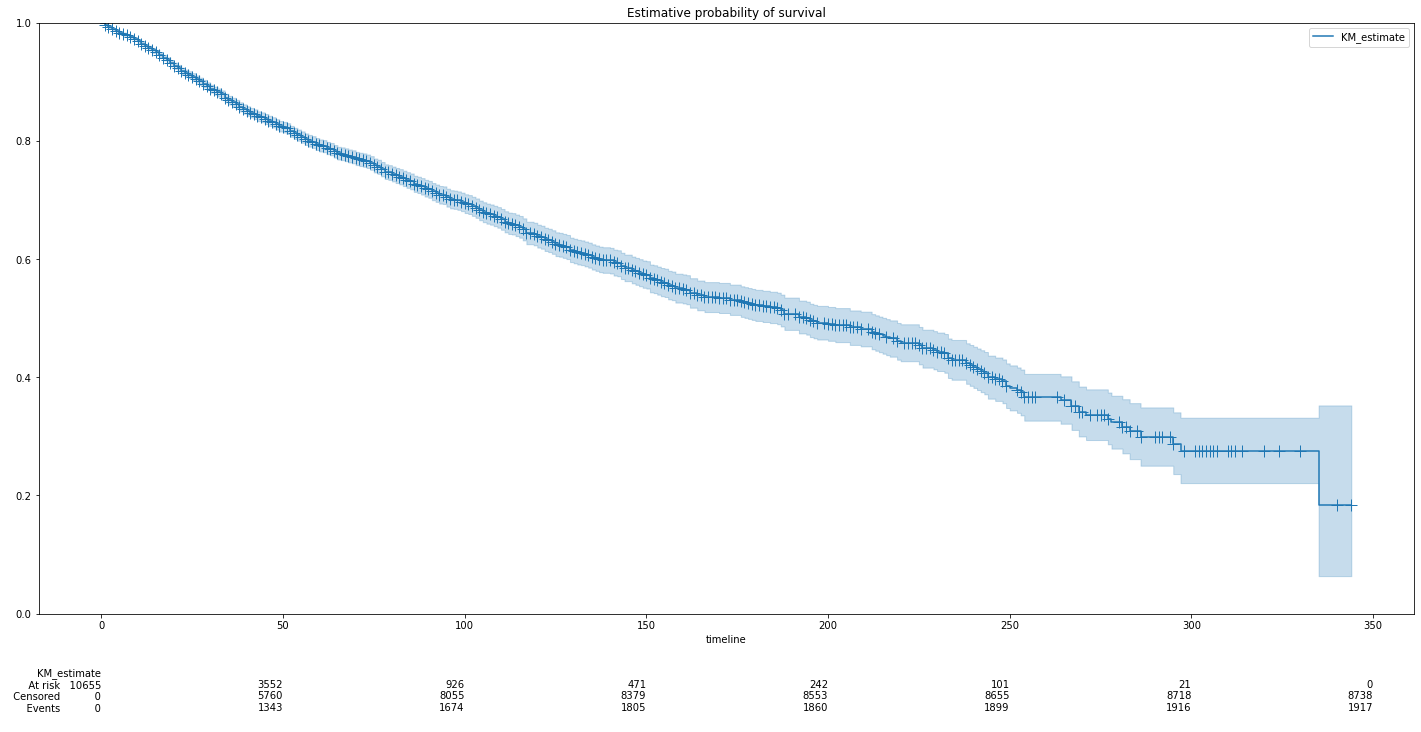

In [28]:
# Plotar KM com todos os dados de câncer de mama
kmf = KaplanMeierFitter()

plt.figure(figsize=(20,10))
kmf.fit(df_final_use['duracao'], event_observed=df_final_use['desfecho'])
kmf.plot_survival_function(at_risk_counts=True, show_censors=True)
plt.title('Estimative probability of survival')
plt.ylim(0, 1)

In [29]:
# Obter a mediana de tempo
kmf.median_survival_time_

195.0

In [30]:
# Obter o intervalo de confiança da mediana
ic = kmf.confidence_interval_
median_survival_times(ic)

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.5,178.0,216.0


In [31]:
# Criar tabela de survival de mama
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,10655,10655
1.0,232,45,187,0,10655
2.0,192,38,154,0,10423
3.0,197,29,168,0,10231
4.0,173,28,145,0,10034
...,...,...,...,...,...
324.0,2,0,2,0,6
330.0,1,0,1,0,4
335.0,1,1,0,0,3


In [32]:
# Criar a função de sobrevida
f_sobrevida = kmf.survival_function_.reset_index()
f_sobrevida

,timeline,KM_estimate
0,0.0,1.000000
1,1.0,0.995777
2,2.0,0.992146
3,3.0,0.989334
4,4.0,0.986573
...,...,...
293,324.0,0.274799
294,330.0,0.274799
295,335.0,0.183199
296,340.0,0.183199


## Importar RCBP

In [ ]:
# Conectar ao GCP e Bigquery
client = bigquery.Client()
table_id = "kaplan-meier.fake.rcbp"
table = client.get_table(table_id)

In [ ]:
# Importar dataset a partir da Bigquery
df2 = client.list_rows(table).to_dataframe()

In [34]:
# Visualizar o dataset
df2.head()

,Código do Paciente,Nome do RCBP,Sexo,Data de Nascimento,Idade,Raca/Cor,Nacionalidade,Naturalidade Estado,Naturalidade,Grau de Instrução,Estado Civil,Código Profissão,Nome Profissão,Estado Endereço,Cidade Endereço,Descrição da Topografia,Código da Topografia,Descrição da Morfologia,Código da Morfologia,Descrição da Doenca,Código da Doenca,Descrição da Doenca Infantil,Código da Doenca Infantil,Descrição da Doenca Adulto Jovem,Código da Doenca Adulto Jovem,Indicador de Caso Raro,Meio de Diagnostico,Extensão,Lateralidade,Estadiamento,TNM,Status Vital,Tipo do Obito,Data do Óbito,Data de Último Contato,Data de Diagnostico,Metástase à distância,Unnamed: 37
0,NaN,RCBP GOIÂNIA,FEMININO,11/03/1943,68.0,BRANCO,NaN,NaN,NaN,SEM INFORMAÇÃO,SEM INFORMAÇÃO,0.0,SEM INFORMAÇÃO\t,GOIAS,GOIÂNIA,"BEXIGA, SOE",C679,ADENOCARCINOMA MUCINOSO,84803,"BEXIGA, SOE",C679,Outros carcinomas malignos não especificados,XI-F,CARCINOMA DE BEXIGA,8.5.2,NaN,HISTOLOGIA DO TUMOR PRIMÁRIO,SEM INFORMAÇÃO,NaN,NaN,NaN,NaN,NaN,NaT,NaT,2012-02-28,NaN,NaN
1,NaN,RCBP GOIÂNIA,FEMININO,10/04/1966,46.0,SEM INFORMAÇÃO,NaN,NaN,NaN,SEM INFORMAÇÃO,SEM INFORMAÇÃO,0.0,SEM INFORMAÇÃO\t,GOIAS,GOIÂNIA,"PULMAO, SOE",C349,"ADENOCARCINOMA, SOE",81403,"BRONQUIOS OU PULMOES, SOE",C349,Outros carcinomas malignos não especificados,XI-F,"CARCINOMA DE TRAQUÉIA, BRÔNQUIOS E PULMÃO",8.3,NaN,HISTOLOGIA DO TUMOR PRIMÁRIO,METÁSTASE,NaN,NaN,NaN,NaN,NaN,2013-04-03,NaT,2012-06-11,NaN,NaN
2,NaN,RCBP GOIÂNIA,FEMININO,05/05/1924,88.0,BRANCO,NaN,NaN,NaN,SEM INFORMAÇÃO,CASADO,0.0,SEM INFORMAÇÃO\t,GOIAS,GOIÂNIA,PELE DO MEMBRO INFERIOR E DO QUADRIL,C447,"CARCINOMA ESCAMOCELULAR, SOE",80703,PELE DO MEMBRO INFERIOR E DO QUADRIL,C447,Carcinoma de pele,XI-E,CARCINOMA DE PELE,7.2,NaN,HISTOLOGIA DO TUMOR PRIMÁRIO,LOCALIZADO,NaN,NaN,NaN,NaN,NaN,NaT,NaT,2012-09-14,NaN,NaN
3,NaN,RCBP GOIÂNIA,FEMININO,10/03/1947,65.0,BRANCO,NaN,NaN,NaN,SEM INFORMAÇÃO,CASADO,0.0,SEM INFORMAÇÃO\t,GOIAS,GOIÂNIA,PELE DO TRONCO,C445,MELANOMA DE PROPAGACAO SUPERFICIAL,87433,MELANOMA MALIGNO DO TRONCO,C435,Melanoma maligno,XI-D,MELANOMA,7.1,NaN,HISTOLOGIA DO TUMOR PRIMÁRIO,LOCALIZADO,NaN,NaN,NaN,NaN,NaN,NaT,NaT,2012-08-14,NaN,NaN
4,NaN,RCBP GOIÂNIA,FEMININO,30/01/1948,63.0,BRANCO,NaN,NaN,NaN,SEM INFORMAÇÃO,SEM INFORMAÇÃO,0.0,SEM INFORMAÇÃO\t,GOIAS,GOIÂNIA,PALPEBRA,C441,"CARCINOMA ESCAMOCELULAR, SOE",80703,PELE DA PALPEBRA E CANTO,C441,Carcinoma de pele,XI-E,CARCINOMA DE PELE,7.2,NaN,HISTOLOGIA DO TUMOR PRIMÁRIO,LOCALIZADO,NaN,NaN,NaN,NaN,NaN,NaT,NaT,2012-03-01,NaN,NaN


In [35]:
df2 = df2[['Status Vital', 'Data de Diagnostico', 'Data do Óbito', 'Data de Último Contato', 'Código da Topografia', 'Código da Morfologia']]

## Preparo RCBP

In [36]:
# Transformar o evento (Statis Vital) em True e False ou NaN
df2['obito'] = df2['Status Vital']
df2['obito'] = df2['obito'].mask(df2['obito'] == "MORTO", True)
df2['obito'] = df2['obito'].mask(df2['obito'] == "VIVO", False)
df2['obito'] = df2['obito'].mask(df2['obito'] == "SEM INFORMAÇÃO", False)
df2['obito'] = df2['obito'].mask(df2['obito'].isna(), False)

In [37]:
# Verificar as quantidades de pacients vivos ou mortos
# True = MORTO
# False = Vivo
df2["obito"].value_counts(dropna=False)

False    665900
True      77056
Name: obito, dtype: int64

In [38]:
# Pegar todos que tenham data de diagnóstico (startdate)
# Todos devem ter
df2_parcial = df2[-df2["Data de Diagnostico"].isna()]

In [39]:
# Pegar todos que tenham data de óbito caso tenha morrido
# Descartar quem morreu e não tem data do óbito
df2_morto = df2_parcial[df2_parcial['obito'] == True]
df2_morto = df2_morto[-df2_morto['Data do Óbito'].isna()]

In [40]:
# Pegar todos que tem data de último contato caso estejam vivo ou não tenha informação
# Descartar quem está vivo e não tem data do último contato
df2_vivo = df2_parcial[(df2_parcial['obito'] == False) | (df2_parcial['obito'].isna())]
df2_vivo = df2_vivo[-df2_vivo['Data de Último Contato'].isna()]

In [41]:
# Contatenar os datasets de quem morreu e quem tá vivo e contenha as infos (Data do óbito e data do último contato) necessárias 
df2_final = df2_morto.append(df2_vivo, ignore_index=False)

In [42]:
# Verificar quantos Mortos e Vivos
df2_final['obito'].value_counts(dropna=False)

False    163842
True      77051
Name: obito, dtype: int64

In [43]:
# Formatar as datas
df2_final['Data de Diagnostico'] = pd.to_datetime(df2_final['Data de Diagnostico'], format='%Y-%m-%d')
df2_final['Data do Óbito'] = pd.to_datetime(df2_final['Data do Óbito'], format='%Y-%m-%d')
df2_final['Data de Último Contato'] = pd.to_datetime(df2_final['Data de Último Contato'], format='%Y-%m-%d')

In [44]:
# Criar coluna com o enddate os pacientes
# Caso o paciente morreru a coluna enddate considerará a data do óbito
# Caso o paciente esteja vivo a coluna enddate considerará a data do último contato
mortos2 = df2_final['obito'] == True
vivos2 = (df2_final['obito'] == False) | (df2_final['obito'].isna())
teste_mortos2 = df2_final['Data do Óbito'][mortos2]
teste_vivos2 = df2_final['Data de Último Contato'][vivos2]

# Contatenr o dataset findal com a coluna enddate
df2_final['enddate'] = pd.concat([teste_mortos2, teste_vivos2], axis=0)

In [45]:
# Visualiar o dataset final
df2_final.head()

,Status Vital,Data de Diagnostico,Data do Óbito,Data de Último Contato,Código da Topografia,Código da Morfologia,obito,enddate
279333,MORTO,2011-09-01,2011-09-01,2011-09-01,C629,80003,True,2011-09-01
279470,MORTO,2011-09-21,2011-09-21,2011-09-21,C109,80003,True,2011-09-21
279486,MORTO,2011-11-13,2011-11-13,2011-11-13,C349,80003,True,2011-11-13
279508,MORTO,2011-08-15,2011-08-15,2011-08-15,C449,97003,True,2011-08-15
279509,MORTO,2011-11-13,2011-11-13,2011-11-13,C421,98633,True,2011-11-13


In [46]:
# Análise dos pacientes com câncer de pulmão
# Tudo que tem CID que comece por C34
df_pulmao = df2_final[df2_final['Código da Topografia'].str.startswith('C34')].copy()

## Preparo da variável duração com multiprocessador

In [47]:
# Função para coletar o tempo de cada indíviduo
# Tempo até a morte
# Ou tempo até último contato
# Definido o tempo em meses (possível alterar a frequência)
def coleta_tempo2(i):
    dataframe = df_pulmao
    return dataframe['enddate'].dt.to_period('M').astype(int)[i] - dataframe['Data de Diagnostico'].dt.to_period('M').astype(int)[i]

In [48]:
# Coletar o tempo utilizando multiprocessamento (agilizar o processo)
duracao2 = process_map(coleta_tempo2, df_pulmao.index, max_workers=8, chunksize=10)

In [49]:
# Criar a coluna no dataset final com os tempo coletados
df_pulmao['duracao'] = duracao2
df_pulmao

,Status Vital,Data de Diagnostico,Data do Óbito,Data de Último Contato,Código da Topografia,Código da Morfologia,obito,enddate,duracao
279486,MORTO,2011-11-13,2011-11-13,2011-11-13,C349,80003,True,2011-11-13,0
279693,MORTO,2011-12-18,2011-12-18,2011-12-18,C349,80003,True,2011-12-18,0
279833,MORTO,2011-09-28,2011-09-28,2011-09-28,C349,80003,True,2011-09-28,0
279934,MORTO,2011-01-11,2011-01-11,2011-01-11,C349,80003,True,2011-01-11,0
280178,MORTO,2011-09-18,2011-09-18,2011-09-18,C349,80003,True,2011-09-18,0
...,...,...,...,...,...,...,...,...,...
723962,VIVO,2014-09-09,NaT,2021-04-19,C349,80103,False,2021-04-19,79
724423,VIVO,2014-11-21,NaT,2014-12-22,C349,81403,False,2014-12-22,1
724473,VIVO,2014-08-15,NaT,2016-06-30,C349,81403,False,2016-06-30,22
724719,VIVO,2014-09-15,NaT,2015-06-16,C349,81403,False,2015-06-16,9


In [50]:
# Transformar a coluna para o formato esperado para os pacotes
df_pulmao['desfecho'] = df_pulmao['obito'].astype(np.float64)

In [51]:
# Selecionar os pacientes que possuem o tempo maior que 0 para criar o gráfico
df_pulmao_use = df_pulmao[df_pulmao['duracao'] > 0]

## Análise da KM com pacote LIFELINES do rcbp

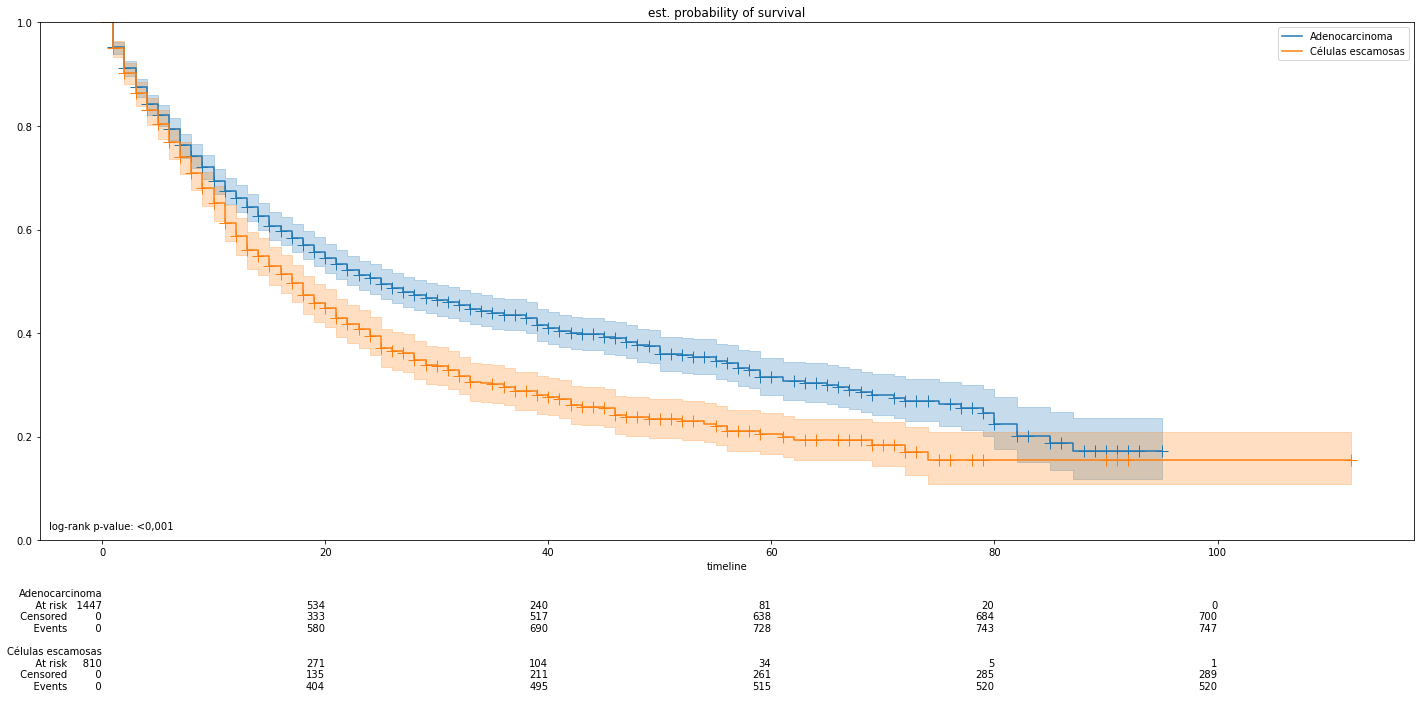

In [52]:
# Plotar KM comparando câncer de pulmão C34
# Morfologias 81403 e 80703
fig, ax = plt.subplots(figsize=(20, 10))
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

pulmao_81403 = (df_pulmao_use['Código da Morfologia'] == 81403)
pulmao_80703 = (df_pulmao_use['Código da Morfologia'] == 80703)

kmf1.fit(df_pulmao_use['duracao'][pulmao_81403], event_observed = df_pulmao_use['desfecho'][pulmao_81403], label="Adenocarcinoma")
kmf1.plot_survival_function(ax=ax, show_censors=True)

kmf2.fit(df_pulmao_use['duracao'][pulmao_80703], event_observed = df_pulmao_use['desfecho'][pulmao_80703], label="Células escamosas")
kmf2.plot_survival_function(ax=ax, show_censors=True)

add_at_risk_counts(kmf1, kmf2, ax=ax)
results = logrank_test(df_pulmao_use['duracao'][pulmao_81403], df_pulmao_use['duracao'][pulmao_80703], df_pulmao_use['desfecho'][pulmao_81403], df_pulmao_use['desfecho'][pulmao_80703], alpha=.99)

if results.p_value < 0.001:
    results = '<0,001'
else:
    results = '{:.3}'.format(results.p_value)

plt.title("est. probability of survival")
plt.ylim(0, 1)
anchored_text = AnchoredText(f"log-rank p-value: {results}", loc=3, frameon=False)
ax.add_artist(anchored_text)
plt.tight_layout()

In [53]:
# Análise estatística de logrank para avaliar a diferença de tempo entre os grupos
# Resultado é signfificativo
results = logrank_test(df_pulmao_use['duracao'][pulmao_81403], df_pulmao_use['duracao'][pulmao_80703], df_pulmao_use['desfecho'][pulmao_81403], df_pulmao_use['desfecho'][pulmao_80703], alpha=.95)
results.print_summary()

TypeError: unsupported format string passed to Styler.__format__

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          25.53 <0.005     21.13

In [54]:
# Mediana de sobrevida de cada curva criada
kmf1.median_survival_time_, kmf2.median_survival_time_

(25.0, 17.0)